In [1]:
import os
import random
import torch
import torchaudio
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.metrics import roc_curve, accuracy_score, precision_score, recall_score, f1_score, auc # type: ignore
import matplotlib.pyplot as plt
from transformers import HubertModel, AutoProcessor
from tqdm import tqdm
import pickle

# ASV

In [ ]:
audio_folder = "ASV/Data"
protocol_file = "ASV/Labels.txt" 

asv_files = [f for f in os.listdir(audio_folder) if f.endswith(".flac")]
print(f"Found {len(asv_files)} audio files.")

random_files = random.sample(asv_files, min(5, len(asv_files)))
print("Randomly sampled filenames:")
for filename in random_files:
    print(filename)

In [ ]:
label_dict = {}
with open(protocol_file, "r") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) < 5:
            continue
        _, filename, _, _, label = parts
        label_dict[filename + ".flac"] = 1 if label == "bonafide" else 0

# FoR

In [ ]:
real_audio_folder = "FoR/training/real"
fake_audio_folder = "FoR/training/fake"

real_files = [os.path.join(real_audio_folder, f) for f in os.listdir(real_audio_folder) if f.endswith(".wav")]
fake_files = [os.path.join(fake_audio_folder, f) for f in os.listdir(fake_audio_folder) if f.endswith(".wav")]

for_train_files = real_files + fake_files

real_label = [1] * len(real_files)  
fake_label = [0] * len(fake_files)

train_labels = np.array(real_label + fake_label, dtype=np.int8)

print(f"Label array created with {len(train_labels)} labels, matching {len(for_train_files)} audio files.")


print(f"Found {len(real_files)} real audio files and {len(fake_files)} fake audio files.")
print(f"Total train audio files: {len(for_train_files)}")

In [10]:
real_audio_folder = "FoR/testing/real"
fake_audio_folder = "FoR/testing/fake"

real_files = [os.path.join(real_audio_folder, f) for f in os.listdir(real_audio_folder) if f.endswith(".wav")]
fake_files = [os.path.join(fake_audio_folder, f) for f in os.listdir(fake_audio_folder) if f.endswith(".wav")]

for_testing_files = real_files + fake_files

real_label = [1] * len(real_files)  
fake_label = [0] * len(fake_files)

test_labels = np.array(real_label + fake_label, dtype=np.int8)

print(f"Label array created with {len(test_labels)} labels, matching {len(for_testing_files)} audio files.")

print(f"Found {len(real_files)} real audio files and {len(fake_files)} fake audio files.")
print(f"Total test audio files: {len(for_testing_files)}")

Label array created with 4634 labels, matching 4634 audio files.
Found 2264 real audio files and 2370 fake audio files.
Total test audio files: 4634


In [ ]:
real_audio_folder = "FoR/validation/real"
fake_audio_folder = "FoR/validation/fake"

real_files = [os.path.join(real_audio_folder, f) for f in os.listdir(real_audio_folder) if f.endswith(".wav")]
fake_files = [os.path.join(fake_audio_folder, f) for f in os.listdir(fake_audio_folder) if f.endswith(".wav")]

for_validation_files = real_files + fake_files

real_label = [1] * len(real_files)  
fake_label = [0] * len(fake_files)

validation_labels = np.array(real_label + fake_label, dtype=np.int8)

print(f"Label array created with {len(validation_labels)} labels, matching {len(for_validation_files)} audio files.")

print(f"Found {len(real_files)} real audio files and {len(fake_files)} fake audio files.")
print(f"Total validate audio files: {len(for_validation_files)}")

# Hubert

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = AutoProcessor.from_pretrained("facebook/hubert-large-ls960-ft")
model = HubertModel.from_pretrained("facebook/hubert-large-ls960-ft").to(device)
model.eval()

In [ ]:
BATCH_SIZE = 32

def process_batch(filenames):
    waveforms = []
    labels = []
    features = []
    
    for filename in filenames:
        file_path = os.path.join(audio_folder, filename)
        waveform, sample_rate = torchaudio.load(file_path)
        waveform = waveform.to(device)

        if sample_rate != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
            waveform = resampler(waveform)

        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        waveforms.append(waveform.squeeze(0))
        labels.append(label_dict.get(filename, -1))
        
    with torch.no_grad():
        for waveform in waveforms:
            inputs = processor(waveform, sampling_rate=16000, return_tensors="pt").to(device)
            outputs = model(**inputs)
            features.append(outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten())

    return features, labels
            

In [ ]:
features, labels = [], []
for i in tqdm(range(0, len(asv_files), BATCH_SIZE), desc="Extracting features"):
    batch_files = asv_files[i:i+BATCH_SIZE]
    batch_features, batch_labels = process_batch(batch_files)
    
    features.extend(batch_features)
    labels.extend(batch_labels)

features = np.array(features, dtype=np.float32)
labels = np.array(labels, dtype=np.int8)

output_file = "ASV_Dataset.pkl"
with open(output_file, "wb") as f:
    pickle.dump({"features": features, "labels": labels}, f)

print(f"Saved extracted features to {output_file}")

In [ ]:
BATCH_SIZE = 32

def process_batch(filenames):
    waveforms = []
    features = []
    
    for filename in filenames:
        try:
            waveform, sample_rate = torchaudio.load(filename)
            waveform = waveform.to(device)

            if sample_rate != 16000:
                resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
                waveform = resampler(waveform)

            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)

            waveforms.append(waveform.squeeze(0))
        except RuntimeError as e:
            print(f"Error loading {filename}: {e}")
            continue 

    with torch.no_grad():
        for waveform in waveforms:
            inputs = processor(waveform, sampling_rate=16000, return_tensors="pt").to(device)
            outputs = model(**inputs)
            features.append(outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten())

    return features

In [ ]:
def get_pkl(files, output_file):
    features, labels = [], []
    for i in tqdm(range(0, len(files), BATCH_SIZE), desc="Extracting features"):
        batch_files = files[i:i+BATCH_SIZE]
        batch_labels = train_labels[i:i+BATCH_SIZE]
        batch_features = process_batch(batch_files)
        
        features.extend(batch_features)
        labels.extend(batch_labels)

    features = np.array(features, dtype=np.float32)
    labels = np.array(labels, dtype=np.int8)

    with open(output_file, "wb") as f:
        pickle.dump({"features": features, "labels": labels}, f)

    print(f"Saved extracted features to {output_file}")

In [ ]:
get_pkl(for_train_files, "FoR_Train_Dataset.pkl")

In [9]:
get_pkl(for_testing_files, "FoR_Test_Dataset.pkl")

NameError: name 'for_testing_files' is not defined

In [ ]:
get_pkl(for_validation_files, "FoR_Validation_Dataset.pkl")

# Model

In [2]:
class DeepfakeDataset(Dataset):
    def __init__(self, data_dict):
        self.features = torch.tensor(data_dict["features"], dtype=torch.float32)
        self.labels = torch.tensor(data_dict["labels"], dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class MaxFeatureMap1D(nn.Module):
    def forward(self, x):
        out = x.view(x.size(0), x.size(1) // 2, 2, x.size(2))
        out = out.max(dim=2)[0]
        return out

class DeepfakeClassifier(nn.Module):
    def __init__(self, input_dim=1024, hidden_dim=512, lstm_hidden_dim=256, num_classes=2):
        super(DeepfakeClassifier, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()

        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, stride=1, padding=2)
        self.mfm1 = MaxFeatureMap1D()  
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=1, stride=1)
        self.mfm2 = MaxFeatureMap1D()
        self.batchnorm1 = nn.BatchNorm1d(32)
        self.conv3 = nn.Conv1d(32, 96, kernel_size=3, stride=1, padding=1)
        self.mfm3 = MaxFeatureMap1D()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.batchnorm2 = nn.BatchNorm1d(48)
        self.conv4 = nn.Conv1d(48, 96, kernel_size=1, stride=1)
        self.mfm4 = MaxFeatureMap1D()
        self.batchnorm3 = nn.BatchNorm1d(48)
        self.conv5 = nn.Conv1d(48, 128, kernel_size=3, stride=1, padding=1)
        self.mfm5 = MaxFeatureMap1D()
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=lstm_hidden_dim, num_layers=1, 
                             bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=lstm_hidden_dim * 2, hidden_size=lstm_hidden_dim, num_layers=1, 
                             bidirectional=True, batch_first=True)

        self.gap = nn.AdaptiveAvgPool1d(1)

        self.fc2 = nn.Linear(lstm_hidden_dim * 2, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)

        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.mfm1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.mfm2(x)
        x = self.batchnorm1(x)
        x = self.conv3(x)
        x = self.mfm3(x)
        x = self.pool2(x)
        x = self.batchnorm2(x)
        x = self.conv4(x)
        x = self.mfm4(x)
        x = self.batchnorm3(x)
        x = self.conv5(x)
        x = self.mfm5(x)
        x = self.pool3(x)

        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)

        x = x.permute(0, 2, 1)
        x = self.gap(x).squeeze(-1)
        
        x = self.fc2(x)
        return x

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepfakeClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
num_epochs = 50

def Train(train_loader, val_loader, eer_per_epoch):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)

        model.eval()
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                
                probs = torch.softmax(outputs, dim=1)[:, 1]

                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.detach().cpu().numpy())

        all_labels = np.array(all_labels)
        all_probs = np.array(all_probs)

        fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
        fnr = 1 - tpr
        
        eer_index = np.nanargmin(np.abs(fpr - fnr))
        eer = fpr[eer_index]

        eer_per_epoch.append(eer)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Val EER: {eer:.4f}")

In [5]:
def Test(test_loader, name):
    all_labels = []
    all_preds = []
    all_probs = []

    model.eval()
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)

            probs = torch.softmax(outputs, dim=1)[:, 1]
            preds = torch.argmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    TP = np.sum((all_preds == 1) & (all_labels == 1))
    TN = np.sum((all_preds == 0) & (all_labels == 0))
    FP = np.sum((all_preds == 1) & (all_labels == 0))
    FN = np.sum((all_preds == 0) & (all_labels == 1))

    fpr_manual = FP / (FP + TN) if (FP + TN) > 0 else 0.0
    fnr_manual = FN / (FN + TP) if (FN + TP) > 0 else 0.0

    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    fnr = 1 - tpr

    eer_index = np.nanargmin(np.abs(fpr - fnr))
    eer = fpr[eer_index]
    
    print("Evaluation Metrics on Test Set:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"FPR:       {fpr_manual:.4f}")
    print(f"FNR:       {fnr_manual:.4f}")
    print(f"EER:       {eer:.4f}")
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc(fpr, tpr):.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")
    plt.scatter(fpr[eer_index], tpr[eer_index], color='red', label=f"EER Point ({eer:.4f})")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(name + "ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
with open("ASV_Dataset.pkl", "rb") as f:
    data = pickle.load(f)

features = data["features"]
labels = data["labels"]

valid_indices = (labels == 0) | (labels == 1)

filtered_features = features[valid_indices]
filtered_labels = labels[valid_indices]

cleaned_data = {"features": filtered_features, "labels": filtered_labels}
print(filtered_features.shape)
print(filtered_labels.shape)

(71237, 1024)
(71237,)


In [8]:
dataset = DeepfakeDataset(cleaned_data)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

ASV_train_dataset, ASV_val_dataset, ASV_test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(ASV_train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(ASV_val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(ASV_test_dataset, batch_size=64, shuffle=False)

print(f"Training samples: {train_size}, Validation samples: {val_size}, Testing samples: {test_size}")

Training samples: 56989, Validation samples: 7123, Testing samples: 7125


In [49]:
ASV_eer_per_epoch = []
Train(train_loader, val_loader, ASV_eer_per_epoch)

Epoch 1/50, Loss: 0.1791, Test EER: 0.0615
Epoch 2/50, Loss: 0.0927, Test EER: 0.0543
Epoch 3/50, Loss: 0.0788, Test EER: 0.0435
Epoch 4/50, Loss: 0.0742, Test EER: 0.0441
Epoch 5/50, Loss: 0.0678, Test EER: 0.0410
Epoch 6/50, Loss: 0.0651, Test EER: 0.0366
Epoch 7/50, Loss: 0.0618, Test EER: 0.0392
Epoch 8/50, Loss: 0.0589, Test EER: 0.0344
Epoch 9/50, Loss: 0.0598, Test EER: 0.0336
Epoch 10/50, Loss: 0.0548, Test EER: 0.0326
Epoch 11/50, Loss: 0.0558, Test EER: 0.0326
Epoch 12/50, Loss: 0.0525, Test EER: 0.0333
Epoch 13/50, Loss: 0.0520, Test EER: 0.0322
Epoch 14/50, Loss: 0.0496, Test EER: 0.0298
Epoch 15/50, Loss: 0.0514, Test EER: 0.0300
Epoch 16/50, Loss: 0.0488, Test EER: 0.0303
Epoch 17/50, Loss: 0.0469, Test EER: 0.0312
Epoch 18/50, Loss: 0.0469, Test EER: 0.0290
Epoch 19/50, Loss: 0.0450, Test EER: 0.0289
Epoch 20/50, Loss: 0.0454, Test EER: 0.0279
Epoch 21/50, Loss: 0.0441, Test EER: 0.0400
Epoch 22/50, Loss: 0.0446, Test EER: 0.0268
Epoch 23/50, Loss: 0.0432, Test EER: 0.02

Evaluation Metrics on Test Set:
Accuracy:  0.9829
Precision: 0.9187
Recall:    0.9137
F1 Score:  0.9162
FPR:       0.0092
FNR:       0.0863
EER:       0.0274


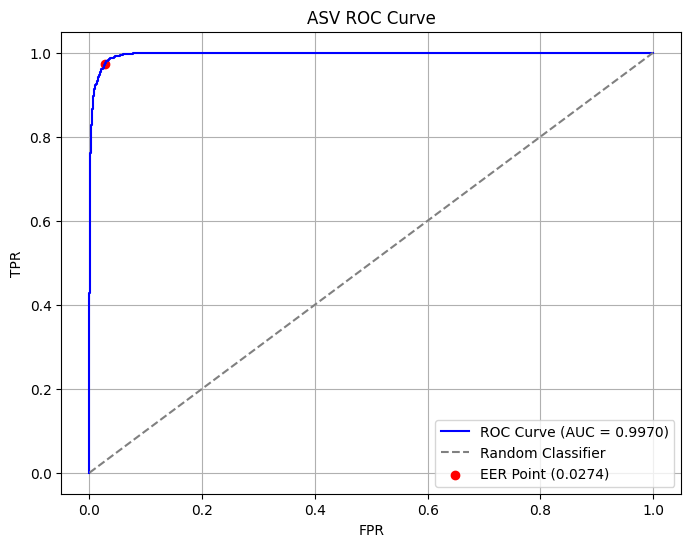

In [52]:
Test(test_loader, "ASV ")

In [9]:
with open("FoR_Train_Dataset.pkl", "rb") as f:
    for_train_data = pickle.load(f)

with open("FoR_Validation_Dataset.pkl", "rb") as f:
    for_val_data = pickle.load(f)

with open("FoR_Test_Dataset.pkl", "rb") as f:
    for_test_data = pickle.load(f)
    
    
FoR_train_dataset = DeepfakeDataset(for_train_data)
FoR_val_dataset = DeepfakeDataset(for_val_data)
FoR_test_dataset = DeepfakeDataset(for_test_data)

train_loader = DataLoader(FoR_train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(FoR_val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(FoR_test_dataset, batch_size=64, shuffle=False)


print(f"Training samples: {train_size}, Validation samples: {val_size}, Testing samples: {test_size}")

Training samples: 56989, Validation samples: 7123, Testing samples: 7125


In [54]:
FoR_eer_per_epoch = []
Train(train_loader, val_loader, FoR_eer_per_epoch)

Epoch 1/50, Loss: 0.1890, Test EER: 0.0315
Epoch 2/50, Loss: 0.0612, Test EER: 0.0248
Epoch 3/50, Loss: 0.0451, Test EER: 0.0228
Epoch 4/50, Loss: 0.0339, Test EER: 0.0219
Epoch 5/50, Loss: 0.0290, Test EER: 0.0209
Epoch 6/50, Loss: 0.0288, Test EER: 0.0195
Epoch 7/50, Loss: 0.0218, Test EER: 0.0204
Epoch 8/50, Loss: 0.0210, Test EER: 0.0200
Epoch 9/50, Loss: 0.0183, Test EER: 0.0185
Epoch 10/50, Loss: 0.0180, Test EER: 0.0178
Epoch 11/50, Loss: 0.0160, Test EER: 0.0172
Epoch 12/50, Loss: 0.0157, Test EER: 0.0185
Epoch 13/50, Loss: 0.0144, Test EER: 0.0195
Epoch 14/50, Loss: 0.0142, Test EER: 0.0182
Epoch 15/50, Loss: 0.0134, Test EER: 0.0170
Epoch 16/50, Loss: 0.0121, Test EER: 0.0172
Epoch 17/50, Loss: 0.0117, Test EER: 0.0169
Epoch 18/50, Loss: 0.0133, Test EER: 0.0165
Epoch 19/50, Loss: 0.0117, Test EER: 0.0167
Epoch 20/50, Loss: 0.0103, Test EER: 0.0165
Epoch 21/50, Loss: 0.0109, Test EER: 0.0180
Epoch 22/50, Loss: 0.0095, Test EER: 0.0178
Epoch 23/50, Loss: 0.0095, Test EER: 0.01

Evaluation Metrics on Test Set:
Accuracy:  0.9612
Precision: 0.9689
Recall:    0.9510
F1 Score:  0.9599
FPR:       0.0291
FNR:       0.0490
EER:       0.0384


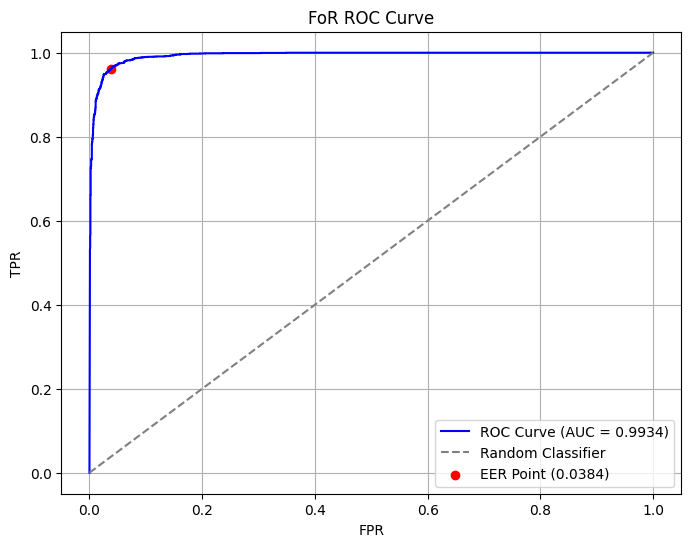

In [55]:
Test(test_loader, "FoR ")

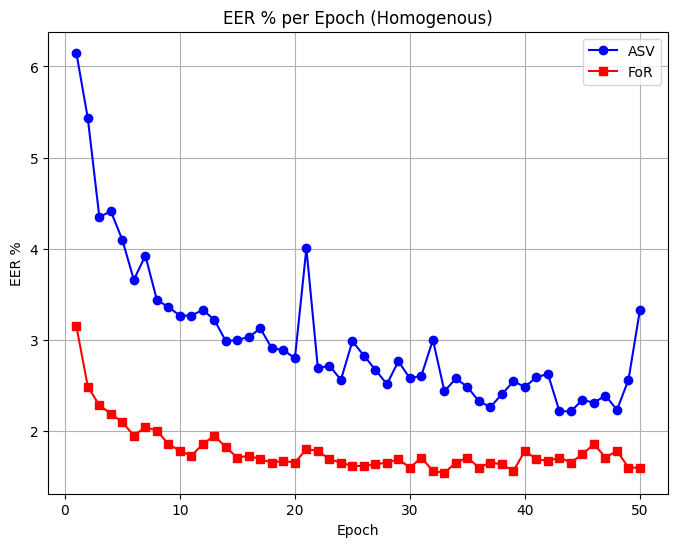

In [56]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), [100*eer for eer in ASV_eer_per_epoch], marker='o', label="ASV", color='b')
plt.plot(range(1, num_epochs+1), [100*eer for eer in FoR_eer_per_epoch], marker='s', label="FoR", color='r')

plt.xlabel("Epoch")
plt.ylabel("EER %")
plt.title("EER % per Epoch (Homogenous)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
train_loader = DataLoader(FoR_train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(ASV_val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(ASV_test_dataset, batch_size=64, shuffle=False)

In [60]:
FoR_ASV_eer_per_epoch = []
Train(train_loader, val_loader, FoR_ASV_eer_per_epoch)

Epoch 1/50, Loss: 0.0041, Test EER: 0.0167
Epoch 2/50, Loss: 0.0068, Test EER: 0.0172
Epoch 3/50, Loss: 0.0060, Test EER: 0.0163
Epoch 4/50, Loss: 0.0037, Test EER: 0.0167
Epoch 5/50, Loss: 0.0074, Test EER: 0.0167
Epoch 6/50, Loss: 0.0027, Test EER: 0.0156
Epoch 7/50, Loss: 0.0076, Test EER: 0.0167
Epoch 8/50, Loss: 0.0036, Test EER: 0.0152
Epoch 9/50, Loss: 0.0036, Test EER: 0.0178
Epoch 10/50, Loss: 0.0039, Test EER: 0.0163
Epoch 11/50, Loss: 0.0060, Test EER: 0.0165
Epoch 12/50, Loss: 0.0024, Test EER: 0.0156
Epoch 13/50, Loss: 0.0027, Test EER: 0.0163
Epoch 14/50, Loss: 0.0058, Test EER: 0.0156
Epoch 15/50, Loss: 0.0023, Test EER: 0.0157
Epoch 16/50, Loss: 0.0051, Test EER: 0.0161
Epoch 17/50, Loss: 0.0034, Test EER: 0.0159
Epoch 18/50, Loss: 0.0060, Test EER: 0.0169
Epoch 19/50, Loss: 0.0061, Test EER: 0.0159
Epoch 20/50, Loss: 0.0010, Test EER: 0.0170
Epoch 21/50, Loss: 0.0106, Test EER: 0.0170
Epoch 22/50, Loss: 0.0011, Test EER: 0.0169
Epoch 23/50, Loss: 0.0013, Test EER: 0.01

Evaluation Metrics on Test Set:
Accuracy:  0.5537
Precision: 0.1883
Recall:    0.9959
F1 Score:  0.3167
FPR:       0.4976
FNR:       0.0041
EER:       0.1469


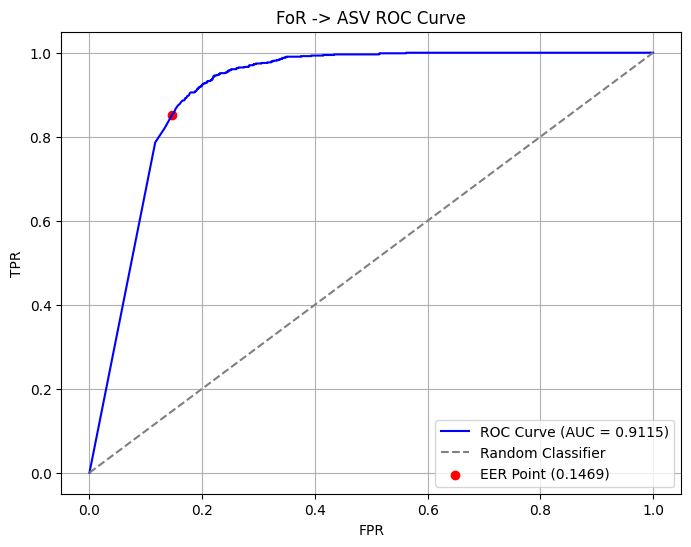

In [62]:
Test(test_loader, "FoR -> ASV ")

In [63]:
train_loader = DataLoader(ASV_train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(FoR_val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(FoR_test_dataset, batch_size=64, shuffle=False)

In [64]:
ASV_FoR_eer_per_epoch = []
Train(train_loader, val_loader, ASV_FoR_eer_per_epoch)

Epoch 1/50, Loss: 0.2468, Test EER: 0.0402
Epoch 2/50, Loss: 0.0991, Test EER: 0.0491
Epoch 3/50, Loss: 0.0814, Test EER: 0.0548
Epoch 4/50, Loss: 0.0722, Test EER: 0.0537
Epoch 5/50, Loss: 0.0652, Test EER: 0.0647
Epoch 6/50, Loss: 0.0637, Test EER: 0.0504
Epoch 7/50, Loss: 0.0600, Test EER: 0.0667
Epoch 8/50, Loss: 0.0566, Test EER: 0.0660
Epoch 9/50, Loss: 0.0543, Test EER: 0.0615
Epoch 10/50, Loss: 0.0531, Test EER: 0.0626
Epoch 11/50, Loss: 0.0512, Test EER: 0.0674
Epoch 12/50, Loss: 0.0493, Test EER: 0.0674
Epoch 13/50, Loss: 0.0495, Test EER: 0.0667
Epoch 14/50, Loss: 0.0482, Test EER: 0.0593
Epoch 15/50, Loss: 0.0465, Test EER: 0.0604
Epoch 16/50, Loss: 0.0453, Test EER: 0.0621
Epoch 17/50, Loss: 0.0461, Test EER: 0.0630
Epoch 18/50, Loss: 0.0442, Test EER: 0.0841
Epoch 19/50, Loss: 0.0436, Test EER: 0.0756
Epoch 20/50, Loss: 0.0441, Test EER: 0.0706
Epoch 21/50, Loss: 0.0430, Test EER: 0.0735
Epoch 22/50, Loss: 0.0459, Test EER: 0.0671
Epoch 23/50, Loss: 0.0436, Test EER: 0.07

Evaluation Metrics on Test Set:
Accuracy:  0.5263
Precision: 1.0000
Recall:    0.0305
F1 Score:  0.0592
FPR:       0.0000
FNR:       0.9695
EER:       0.1873


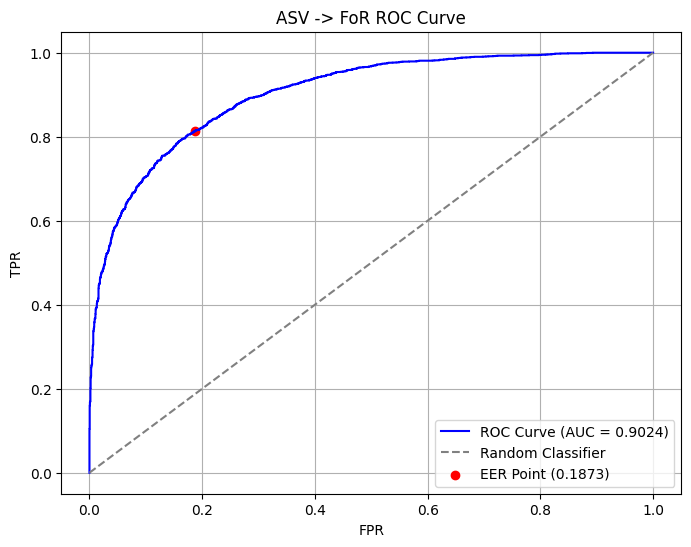

In [65]:
Test(test_loader, "ASV -> FoR ")

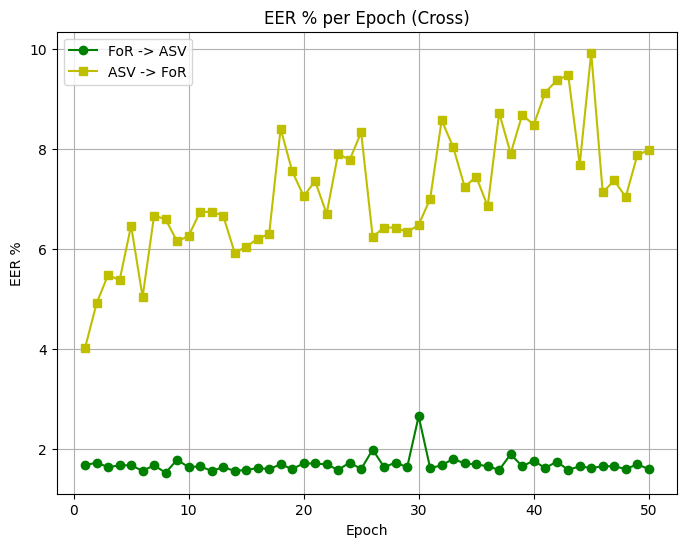

In [66]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), [100*eer for eer in FoR_ASV_eer_per_epoch], marker='o', label="FoR -> ASV", color='g')
plt.plot(range(1, num_epochs+1), [100*eer for eer in ASV_FoR_eer_per_epoch], marker='s', label="ASV -> FoR", color='y')

plt.xlabel("Epoch")
plt.ylabel("EER %")
plt.title("EER % per Epoch (Cross)")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
Combined_train_Dataset = ASV_train_dataset + FoR_train_dataset
Combined_val_Dataset = ASV_val_dataset + FoR_val_dataset
Combined_test_Dataset = ASV_test_dataset + FoR_test_dataset

train_loader = DataLoader(Combined_train_Dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(Combined_val_Dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(Combined_test_Dataset, batch_size=64, shuffle=False)

print(f"Training samples: {len(Combined_train_Dataset)}, Validation samples: {len(Combined_val_Dataset)}, Testing samples: {len(Combined_test_Dataset)}")

Training samples: 110855, Validation samples: 17921, Testing samples: 11759


In [11]:
Combined_eer_per_epoch = []
Train(train_loader, val_loader, Combined_eer_per_epoch)

Epoch 1/50, Loss: 0.1889, Val EER: 0.0534
Epoch 2/50, Loss: 0.1255, Val EER: 0.0503
Epoch 3/50, Loss: 0.1079, Val EER: 0.0464
Epoch 4/50, Loss: 0.0954, Val EER: 0.0787
Epoch 5/50, Loss: 0.0923, Val EER: 0.0321
Epoch 6/50, Loss: 0.0861, Val EER: 0.0342
Epoch 7/50, Loss: 0.0841, Val EER: 0.0362
Epoch 8/50, Loss: 0.0810, Val EER: 0.0320
Epoch 9/50, Loss: 0.0807, Val EER: 0.0460
Epoch 10/50, Loss: 0.0784, Val EER: 0.0274
Epoch 11/50, Loss: 0.0769, Val EER: 0.3434
Epoch 12/50, Loss: 0.0765, Val EER: 0.0726
Epoch 13/50, Loss: 0.0750, Val EER: 0.0417
Epoch 14/50, Loss: 0.0729, Val EER: 0.0346
Epoch 15/50, Loss: 0.0735, Val EER: 0.0654
Epoch 16/50, Loss: 0.0737, Val EER: 0.0295
Epoch 17/50, Loss: 0.0715, Val EER: 0.0428
Epoch 18/50, Loss: 0.0706, Val EER: 0.0551
Epoch 19/50, Loss: 0.0689, Val EER: 0.0682
Epoch 20/50, Loss: 0.0723, Val EER: 0.0271
Epoch 21/50, Loss: 0.0675, Val EER: 0.0464
Epoch 22/50, Loss: 0.0688, Val EER: 0.0351
Epoch 23/50, Loss: 0.0681, Val EER: 0.0404
Epoch 24/50, Loss: 0

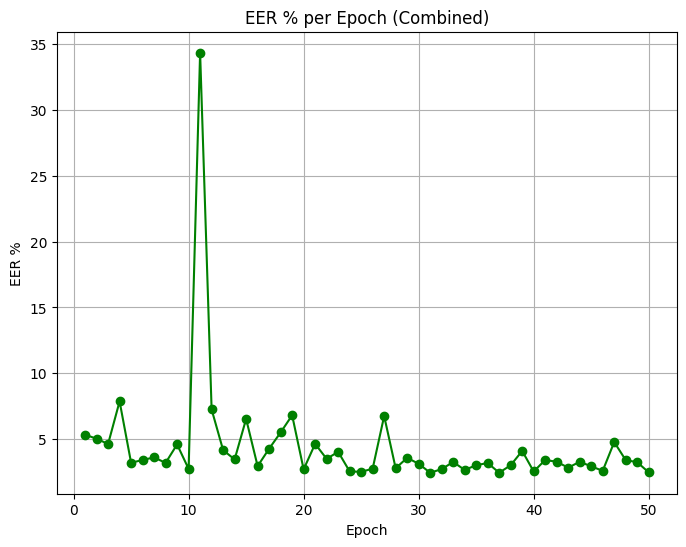

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), [100*eer for eer in Combined_eer_per_epoch], marker='o', label="Combined", color='g')

plt.xlabel("Epoch")
plt.ylabel("EER %")
plt.title("EER % per Epoch (Combined)")
plt.grid(True)
plt.show()

Evaluation Metrics on Test Set:
Accuracy:  0.9457
Precision: 0.9525
Recall:    0.8288
F1 Score:  0.8864
FPR:       0.0142
FNR:       0.1712
EER:       0.0498


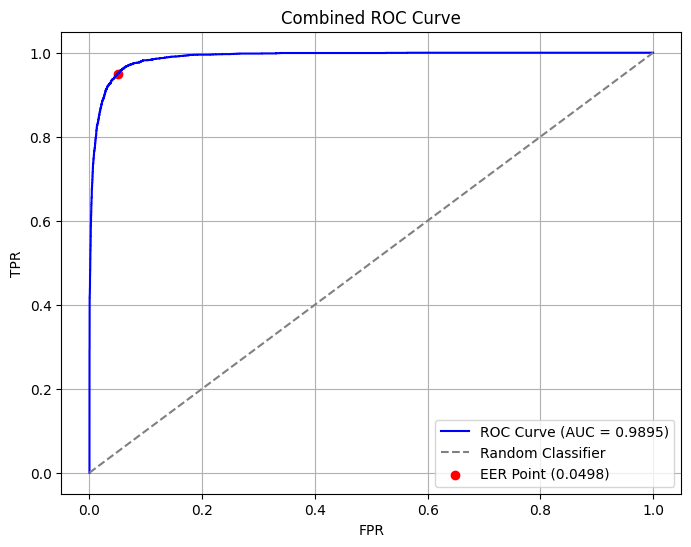

In [13]:
Test(test_loader, "Combined ")